In [1]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, datetime, time, shutil
from importlib import reload 
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gridspec

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

from SWESimulators import IPythonMagic
from SWESimulators import BaseOceanStateEnsemble, OceanNoiseEnsemble, CDKLM16 
from SWESimulators import Common
from SWESimulators import DataAssimilationUtils as dautils



In [2]:
%cuda_context_handler gpu_ctx
%setup_logging --out enkf_gpu.log --file_level 15

Console logger using level INFO
File logger using level Level 15 to enkf_gpu.log
Python version 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]


# Set up an instance 

OceanNoiseEnsemble using CDKLM16-Simulators

In [3]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 60, "ny": 60,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 3,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(dautils)

sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 100,
    "num_drifters": 1,
    "sim": sim,
    "observation_type": dautils.ObservationType.StaticBuoys,
    "buoys_positions" : [[120.0,120.0]],
    "observation_variance": 0.02**2,
    "initialization_variance_factor_ocean_field" : 25.0
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

print ("Ready!")

q0:  0.00017095320928897472
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (60, 60)
max_dt:  0.08877537399530411
Ready!


# Run Simulation until Observation Time

In [4]:
t = 100*sim_args["dt"]
ensemble.step(t)

print("Ready!")

Ready!


# Book keeping

In [6]:
# Size of ensemble
ensemble_size = ensemble_args["numParticles"]

# Number of observers
n_D = ensemble_args["num_drifters"]

# particle properties before EnKF analysis phase
observedParticles_pre = ensemble.observeParticles()
innovationNorms_pre = ensemble.getInnovationNorms()

# rmse values before EnKF analysis phase
ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
rmse_eta_pre = ensemble.rmseUnderDrifter_eta
rmse_hu_pre  = ensemble.rmseUnderDrifter_hu
rmse_hv_pre  = ensemble.rmseUnderDrifter_hv


# Step-By-Step EnKF in Square Root Formulation

## Calculate $S = H X'_f$

In [7]:
"""
Particles are observed in the following form:
[
particle 1:  [hu_1, hv_1], ... , [hu_D, hv_D],
...
particle Ne: [hu_1, hv_1], ... , [hu_D, hv_D]
]

In order to bring it in accordance with later data structure we use the following format for the storage of the perturbation of the observation:
[
[hu_1 (particle 1), ..., hu_1 (particle Ne)],
...
[hu_D (particle 1), ..., hu_D (particle Ne)],
[hv_1 (particle 1), ..., hv_1 (particle Ne)],
...
[hv_D (particle 1), ..., hv_D (particle Ne)],
]

"""

# Observation 
HX_f_orig = ensemble.observeParticles()

# Reshaping
HX_f = np.zeros( (2*n_D, ensemble_size) )
for e in range(ensemble_size):
    for l in range(n_D):
        HX_f[l,e]     = HX_f_orig[e,l,0]
    for l in range(n_D):
        HX_f[n_D+l,e] = HX_f_orig[e,l,1]

HX_f_mean = np.zeros_like(HX_f)
for e in range(ensemble_size):
    HX_f_mean = 1/ensemble_size * HX_f[:,e]

HX_f_pert = HX_f - HX_f_mean.reshape((2*n_D,1))



## Calculate $SS^\top = HPH^\top$ 

In [8]:

HPHT = 1/(ensemble_size-1) * np.dot(HX_f_pert,HX_f_pert.T)


## Calculate $F = HPH^\top + R$

In [9]:
R_orig = ensemble.getObservationCov()

R = np.zeros( (R_orig.shape[0]*n_D, R_orig.shape[1]*n_D) )

for l in range(n_D):
    R[l,l] = R_orig[0,0]
    R[n_D+l, n_D+l] = R_orig[1,1]
    R[l,n_D+l] = R_orig[0,1]
    R[n_D+l,l] = R_orig[1,0]

F = HPHT + R

## Calculate Innovation $D = Y - HX_f$ 
## and perturb $D=D+Y'$

In [10]:
"""
Particles yield innovations in the following form:
[
particle 1:  [hu_1, hv_1], ... , [hu_D, hv_D],
...
particle Ne: [hu_1, hv_1], ... , [hu_D, hv_D]
]

In order to bring it in accordance with later data structure we use the following format for the storage of the perturbation of the observation:
[
[d_hu_1 (particle 1), ..., d_hu_1 (particle Ne)],
...
[d_hu_D (particle 1), ..., d_hu_D (particle Ne)],
[d_hv_1 (particle 1), ..., d_hv_1 (particle Ne)],
...
[d_hv_D (particle 1), ..., d_hv_D (particle Ne)],
]

"""

innovation_orig = ensemble.getInnovations()[:,:,:]

# Reshaping
innovation = np.zeros( (2*n_D, ensemble_size) )
for e in range(ensemble_size):
    for l in range(n_D):
        innovation[l,e]     = innovation_orig[e,l,0]
    for l in range(n_D):
        innovation[n_D+l,e] = innovation_orig[e,l,1]

Y_pert = np.random.multivariate_normal(np.zeros(2*n_D),R ,ensemble_size).T

D = innovation + Y_pert


## Calculate $C = F^{-1}D$

In [11]:
Finv = np.linalg.inv(F)
C = np.dot(Finv,D)

## Calculate $E=S^\top C$


In [12]:
E = np.dot(HX_f_pert.T,C)

## Calculate $X'_f = X_f - \overline{X_f}$ 

In [13]:
"""
The download gives eta = 
[
[eta(x0,y0),...,eta(xN,y0)],
...,
[eta(x0,yN),...,eta(xN,yN)]
]
as an array of size Ny x Nx
and analog for hu and hv.
we use those as an 1D array eta = 
[eta(x0,y0),...,eta(xN,y0),eta(x0,y1),...,eta(xN,y(N-1)),eta(x0,yN),...,eta(xN,yN)]
and anlog for hu and hv 

For further calculations the indivdual dimensions of the state variable are concatinated X = 
[eta, hu, hv]

Collecting the state perturbation for each ensemble member in a matrix Nx x Ne, where
X_f_pert = 
[ 
[eta_pert(x0,y0) (particle 1),..., eta_pert],
...
particle 2: [eta_pert,hu_pert,hv_pert]
]
"""

# Ghost cells added 
n_i = ensemble.particles[0].ny + 4 
n_j = ensemble.particles[0].nx + 4

X_f = np.zeros((3*n_i*n_j, ensemble_size))
for e in range(ensemble_size):
    eta, hu, hv = ensemble.particles[e].download(interior_domain_only=False)
    eta = eta.reshape(n_i*n_j)
    hu  = hu.reshape(n_i*n_j)
    hv  = hv.reshape(n_i*n_j)
    X_f[:,e] = np.append(eta, np.append(hu,hv))

X_f_mean = np.zeros( 3*n_i*n_j )
for e in range(ensemble_size):
    X_f_mean += 1/ensemble_size * X_f[:,e]

X_f_pert = np.zeros_like( X_f )
for e in range(ensemble_size):
    X_f_pert[:,e] = X_f[:,e] - X_f_mean
 

## Calculate $X_a$


In [14]:
X_a = X_f + 1/(ensemble_size-1) * np.dot(X_f_pert,E)

## Reshape and upload analysis state

In [15]:
for e in range(ensemble_size):
    eta = X_a[0:n_i*n_j, e].reshape((n_i,n_j))
    hu  = X_a[n_i*n_j:2*n_i*n_j, e].reshape((n_i,n_j))
    hv  = X_a[2*n_i*n_j:3*n_i*n_j, e].reshape((n_i,n_j))
    ensemble.particles[e].upload(eta,hu,hv)


# Plotting Utils

In [20]:
def _fillPolarPlot(ax, ensemble, observedParticles, alpha, printInfo=False):
    """
    Internal utility function for plotting current under a drifter as a polar plot.
    """
    max_r = 0
    observedParticlesSingleDrifter = observedParticles[:, 0, :]
    if printInfo: print("observedParticlesSingleDrifter: \n" +str(observedParticlesSingleDrifter))
    for p in range(ensemble.getNumParticles()):
        u, v = observedParticlesSingleDrifter[p,0], observedParticlesSingleDrifter[p,1]
        r = np.sqrt(u**2 + v**2)
        max_r = max(max_r, r)
        theta = np.arctan(v/u)
        if (u < 0):
            theta += np.pi
        arr1 = plt.arrow(theta, 0, 0, r, alpha = alpha, \
                         length_includes_head=True, \
                         edgecolor = 'green', facecolor = 'green', zorder = 5)

    obs_u = ensemble.observeTrueState()[0, 2]
    obs_v = ensemble.observeTrueState()[0, 3]
    if printInfo: print("observedTrueState: " + str((obs_u, obs_v)))
    obs_r = np.sqrt(obs_u**2 + obs_v**2)
    max_r = max(max_r, obs_r)
    obs_theta = np.arctan(obs_v/obs_u)
    if (obs_u < 0):
        obs_theta += np.pi
    arr1 = plt.arrow(obs_theta, 0, 0, obs_r, alpha = 0.5,\
                     length_includes_head=True, \
                     edgecolor = 'red', facecolor = 'red', zorder = 5)

    ax.set_rmax(max_r*1.2)
    plt.grid(True)
    plt.title("Momentum observations from drifter")


def _fillHistPlot(ax, ensemble, innovationNorms, alpha, printInfo=False):
    if printInfo: print("innovation norms: " + str(innovationNorms))
    obs_var = ensemble.getObservationVariance()
    range_x = np.sqrt(obs_var)*500
    ax.hist(innovationNorms, bins=30, facecolor='green', \
                range=(0, range_x), alpha=alpha,\
                density=True, label="particle innovations (norm)")
    plt.title("Innovation norms from drifter")


def plotVelocityInfoBeforeAndAfterDA(ensemble, observedParticles, innovationNorms, observedParticles_pre=None, innovationNorms_pre=None, title=None) :

    # Initialize File
    fig = None
    plotRows = 2
    fig = plt.figure(figsize=(10,6))
    gridspec.GridSpec(plotRows, 3)

    # PLOT POSITIONS OF PARTICLES AND OBSERVATIONS
    ax = plt.subplot2grid((plotRows,3), (0,0), polar=True)
    print("Observed particles: \n")
    _fillPolarPlot(ax, ensemble, observedParticles, 0.5, printInfo=True)
    if observedParticles_pre is not None:
        print("Observed particles before: \n")
        _fillPolarPlot(ax, ensemble, observedParticles_pre, 0.1, printInfo=True)
    print("\n\n")

    # PLOT DISCTRIBUTION OF PARTICLE DISTANCES AND THEORETIC OBSERVATION PDF
    ax0 = plt.subplot2grid((plotRows,3), (0,1), colspan=2)
    print("Innovation norms: \n")
    _fillHistPlot(ax0, ensemble, innovationNorms, 0.5, printInfo=True)
    if innovationNorms_pre is not None:
        print("Innovation norms before: \n")
        _fillHistPlot(ax0, ensemble, innovationNorms_pre, 0.1, printInfo=True)

    if title is not None:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()



# Plot circular diagram and histogram

Observed particles: 

observedParticlesSingleDrifter: 
[[-2.92216301  1.00088513]
 [-3.29716206  1.02053726]
 [-2.48931456  0.92387682]
 [-2.63218069  0.96862215]
 [-1.9508847   0.87979162]
 [-3.34141016  1.00534534]
 [-3.3336606   1.04434526]
 [-2.76292348  0.96481985]
 [-1.43222928  0.92403644]
 [-2.2583549   0.96906042]
 [-1.38136351  0.87971014]
 [-2.23848629  0.95492864]
 [-1.59142256  0.89095277]
 [-2.91821957  0.99248213]
 [-2.85471272  0.99160969]
 [-1.46219683  0.87411964]
 [-2.14652467  0.95282555]
 [-2.17082095  0.93561572]
 [-2.57828045  0.97450417]
 [-1.80061889  0.93297404]
 [-2.03710485  0.95115131]
 [-1.17606413  0.88657391]
 [-1.10630798  0.84662145]
 [-2.87000299  0.99265927]
 [-1.00272727  0.81636506]
 [-3.1046977   1.02347589]
 [-2.22764611  0.94492865]
 [-2.56947494  0.97278327]
 [-2.51214504  0.91904783]
 [-2.06556678  0.91037375]
 [-2.45869589  0.96372032]
 [-2.30463552  0.93302238]
 [-3.16959333  1.01877356]
 [-1.78146887  0.90251702]
 [-1.01906264  0.82691306]


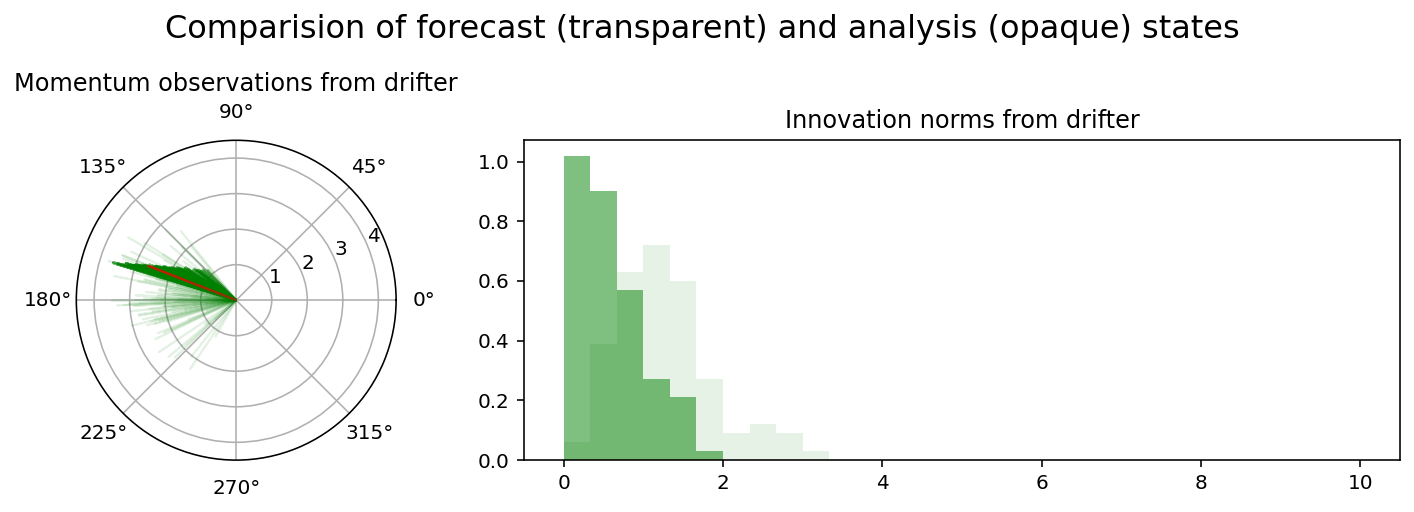

In [21]:
# Download Data from Simulators
observedParticles = ensemble.observeParticles()
innovationNorms = ensemble.getInnovationNorms()

title = "Comparision of forecast (transparent) and analysis (opaque) states"
plotVelocityInfoBeforeAndAfterDA(ensemble, observedParticles, innovationNorms, observedParticles_pre, innovationNorms_pre, title)

## Compare norms of particles before and after assimilation 

In [23]:
for e in range(ensemble_size):
    norm_pre = np.sqrt(np.sum(observedParticles_pre[e,:]**2))
    norm = np.sqrt(np.sum(observedParticles[e,:]**2))
    print("norm before EnKF: ", format(norm_pre, ".6f"), " and norm after EnKF: ", format(norm, ".6f"))

norm before EnKF:  2.878820  and norm after EnKF:  3.088820
norm before EnKF:  3.562270  and norm after EnKF:  3.451489
norm before EnKF:  2.562410  and norm after EnKF:  2.655228
norm before EnKF:  2.598694  and norm after EnKF:  2.804747
norm before EnKF:  1.801692  and norm after EnKF:  2.140090
norm before EnKF:  3.491780  and norm after EnKF:  3.489375
norm before EnKF:  3.341902  and norm after EnKF:  3.493415
norm before EnKF:  2.707165  and norm after EnKF:  2.926538
norm before EnKF:  1.502739  and norm after EnKF:  1.704442
norm before EnKF:  2.186167  and norm after EnKF:  2.457488
norm before EnKF:  1.379413  and norm after EnKF:  1.637698
norm before EnKF:  2.263990  and norm after EnKF:  2.433662
norm before EnKF:  2.142997  and norm after EnKF:  1.823848
norm before EnKF:  3.056719  and norm after EnKF:  3.082373
norm before EnKF:  2.829719  and norm after EnKF:  3.022032
norm before EnKF:  1.266285  and norm after EnKF:  1.703556
norm before EnKF:  2.011029  and norm af

# RMSE Analysis

In [18]:
# rmse values before EnKF analysis phase
ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
rmse_eta = ensemble.rmseUnderDrifter_eta
rmse_hu  = ensemble.rmseUnderDrifter_hu
rmse_hv  = ensemble.rmseUnderDrifter_hv

In [19]:
print("Comparison of RMSE before and after analysis phase\n")
print("RMSE for eta before: ", rmse_eta[0], " and after: ", rmse_eta[1])
print("RMSE for hu  before: ", rmse_hu[0], " and after: ", rmse_hu[1])
print("RMSE for hv  before: ", rmse_hv[0], " and after: ", rmse_hv[1])

Comparison of RMSE before and after analysis phase

RMSE for eta before:  0.008642015793302562  and after:  0.011640134415138163
RMSE for hu  before:  0.2854262936115264  and after:  0.3532246112823487
RMSE for hv  before:  0.7178121410310268  and after:  0.03245793938636776
